<a href="https://colab.research.google.com/github/eomorozova/modeling_hcos/blob/main/HCO_models_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and helper functions

In [2]:
import numpy as np
import scipy as sp
import scipy.io

import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import seaborn as sns
import copy

from scipy.stats import zscore
from sklearn.cluster import KMeans

!pip install -q scanpy
import scanpy as sc
sc.settings.verbosity = 3  

!pip install -q leidenalg

     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 11.2 MB 48.3 MB/s 
     |████████████████████████████████| 88 kB 7.1 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
     |████████████████████████████████| 957 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 4.3 MB/s 
     |████████████████████████████████| 3.1 MB 44.8 MB/s 


In [55]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# concatenate spiketimes

def concat(spiketimes):

  st = []

  for i in range(len(spiketimes)):
    
    st1=[]

    for j in range(len(spiketimes[i])):

      if spiketimes[i][j].any():
        st1.append(np.concatenate(spiketimes[i][j]))
      else:
        st1.append([])

    st.append(st1)
  
  return st

In [5]:
# delete multiple objects from a list 

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
          list_object.pop(idx)

# Load spiketimes

In [6]:
#load spiketime data

from google.colab import files
uploaded = files.upload()

Saving hco_model_data.mat to hco_model_data.mat


In [7]:
mat  = scipy.io.loadmat('/content/hco_model_data.mat')
#mat.keys()
allprtile = mat.get('allprtile') # z-scored feature vector (ISIs, phases)
spiketimes = mat.get('st') # spiketimes

In [8]:
st = concat(spiketimes) # concatinated spiketimes

In [ ]:
# number of models with escape and release 10% asymmerty and 100% asymmetry

ie10 = mat.get('ie10')[0][0]
ir10 = mat.get('ir10')[0][0]
ie100 = mat.get('ie100')[0][0]
ir100 = mat.get('ir100')[0][0]

# Generate synthetic spiketime data

In [ ]:
# function to generate synthetic spiketime data from a Poisson distribution

def generate_st(lambda1):
  s = np.random.poisson(lambda1)
  spikes = []
  time = np.random.poisson(lambda1)

  while (time < 900):
    spikes.append(time)
    time = time + np.random.poisson(lambda1)

  return spikes

In [ ]:
# generate spiketimes for two nerurons
st = []
lambda1=[5,10]

for j in range(2):
  st1 = []
  for i in range(10):
    st1.append(generate_st(lambda1[j]))

  st.append(st1)


# Functions for burst identification and classification of activity patterns

In [9]:
# detect bursts and calculate burst statistics

def DetectBursts(spiketimes, startISI=None, stopISI=None, minspikes=None):
  
  """
  Args:
    spiketimes: spike times of both neurons
    startISI: inter-spike interval to start a burst (in secnds)
    endISI: inter-spike interval to end a burst (in secods)
    minspikes: minimun number of spikes in a burst  

  Returns:
    burst: dictionary with the following collction of key-value pairs
      'N': burst number
      'Nspk': number of spikes per burst
      'FirstSpike': burst onset
      'LastSpike': burst offset
      'BurstDur': burst duration
      'BurstFreq': inter-burst frequency
      'SpkFreq': mean frequency of spikes within bursts

  """
  # defaults
  if startISI is None:
    startISI = np.mean(np.diff(spiketimes))
  if stopISI is None:
    stopISI = startISI + 1
  if minspikes is None:
    minspikes = 2
  
  burst = dict()
  burston, burstoff, burstdur, Nspks = [], [], [], []

  k = 0 # burst counter

  inburst = False

  for i in range(len(spiketimes)):

    
    if i+1<len(spiketimes):

      if (inburst is False) & (spiketimes[i+1]-spiketimes[i]<startISI):

        inburst = True
        k+=1

        firstspike = spiketimes[i]
        burston.append(firstspike)

        nspks = 2 # spike counter

      elif (inburst is True) & (spiketimes[i+1]-spiketimes[i]<stopISI):

        nspks+=1

      else: # check if the number of spikes per burst is more than minimin requires number

        if inburst is True:
          if nspks>=minspikes:

            lastspike = spiketimes[i]
            burstoff.append(lastspike)

            bd = lastspike - firstspike
            burstdur.append(bd)

            Nspks.append(nspks)

        inburst = False

  burstfreq = 1/np.diff(burston)
  spkfreq = Nspks/np.array(burstdur)

  burst = {'N': list(range(1,k)), 'Nspks': Nspks, 'FirstSpike': burston, 'LastSpike': burstoff, 'BurstDur': burstdur, 'BurstFreq': burstfreq, 'SpkFreq': spkfreq.tolist()}

  return burst


In [10]:
# function to detect bursts using a different algorithm

def DetectBurstingNetworks(spiketimes):
  
  """
  Args:
    spiketimes: spike times of both neurons

  Returns:
  state: activity state
  """

  # Detect bursts (approach #1)
  #  Find preliminary bursts by finding ISIs > 4/3*mean(ISIs)
  #  Calculate mean within-burst ISI
  #  Iteratively refine burst detection by finding ISI > mean(within-burst ISI)
  #  Calculate number of spikes per burst and require # spikes/burst > 2
  #  Calculate std(mean(spikes/burst)) and require std(mean(spikes/burst))> 20% of mean(spikes/burst)

  iburst = np.where(np.diff(spiketimes)>4/3*np.mean(np.diff(spiketimes)))
  if len(iburst[0])>0:
    lastspike = spiketimes[iburst]
    firstspike = st[0][j][iburst[0]+1]
    burdur = lastspike[1:]-firstspike[:-1]

    for i in range(100):
      iburst1 = np.where(np.diff(spiketimes)>np.mean(np.diff(lastspike)))
      if len(iburst1[0])<1:
        break
      lastspike = spiketimes[iburst1]
      np.mean(np.diff(lastspike))
      firstspike = st[0][j][iburst1[0]+1]
      burdur = lastspike[1:]-firstspike[:-1]

  else:
    firstspike=[]
    lastspike=[]
    burdur=[]
    
  burst1 = dict()
  burst1 = {'N': len(lastspike), 'LastSpike': lastspike, 'FirstSpike':  firstspike, 'BurstDur': burdur}

  return burst1

In [237]:
# calculate the exclusion factor (based on Grashow et al., 2009)

def Xnetwork(Burst,T):

  """
  Args:
    TimeInterval1: Active time intervals of the 1st neuron, where
      each row contains start end times of the activity periods
    TimeInterval1: Active time intervals of the 2nd neuron
    T: Total simulation time  

  Returns:
    xnetwork: Exclusion factor 
  """
  
  # total active time of the first neuron
  t1 = np.sum(Burst[0]['BurstDur'])

   # total active time of the first neuron
  t2 = np.sum(Burst[1]['BurstDur'])

  if len(Burst[0]['FirstSpike']) > len(Burst[0]['LastSpike']):
    #TimeInterval1 = np.vstack((Burst[0]['FirstSpike'][:-1], Burst[0]['LastSpike'])).T
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'][0:len(Burst[0]['LastSpike'])], Burst[0]['LastSpike'])).T
  elif len(Burst[0]['FirstSpike']) < len(Burst[0]['LastSpike']):    
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'], Burst[0]['LastSpike'][0:len(Burst[0]['FirstSpike'])])).T  
  else:
    TimeInterval1 = np.vstack((Burst[0]['FirstSpike'], Burst[0]['LastSpike'])).T    
  
  if len(Burst[1]['FirstSpike']) > len(Burst[1]['LastSpike']):
    #TimeInterval2 = np.vstack((Burst[1]['FirstSpike'][:-1], Burst[1]['LastSpike'])).T  
    TimeInterval2 = np.vstack((Burst[1]['FirstSpike'][0:len(Burst[1]['LastSpike'])], Burst[1]['LastSpike'])).T    
  elif len(Burst[1]['FirstSpike']) < len(Burst[1]['LastSpike']):
    TimeInterval1 = np.vstack((Burst[1]['FirstSpike'], Burst[1]['LastSpike'][0:len(Burst[1]['FirstSpike'])])).T  
  else:
    TimeInterval2 = np.vstack((Burst[1]['FirstSpike'], Burst[1]['LastSpike'])).T

  if len(TimeInterval1)>len(TimeInterval2):
    TimeInterval1=TimeInterval1[0:len(TimeInterval2)]
  
  if len(TimeInterval2)>len(TimeInterval1):
    TimeInterval2=TimeInterval2[0:len(TimeInterval1)]

  ActiveTime =[]

  for i in range(len(TimeInterval1)):
    SortedIntervals = sorted(TimeInterval1[i].tolist() + TimeInterval2[i].tolist())
    ActiveTime.append(SortedIntervals[-1] - SortedIntervals[0])

  TotalActiveTime = np.sum(ActiveTime)

  # calculate the overlap time (when both neurons are active)
  Onetwork = t1 + t2 - TotalActiveTime

  T=90
  # calculate minimum overlap time between the spiketrains (Omin)
  if t1+t2>T:
    Omin = T - (t1+t2)
  else:
    Omin = 0

  # calculate overlap time expected for uncorrelated inouts  
  if t1+t2>T:
    Orandom = np.min([t1,t2]) - 1/2*(T - np.max([t1,t2]))
  else:
    Orandom = np.min([t1,t2])**2/(2*(T-np.max([t1,t2])))

  # callulate the exclusion factor
  xnetwork = (Orandom - Onetwork)/(Orandom - Omin)

  return xnetwork, TimeInterval1, TimeInterval2 

In [317]:
# function to classify network activity patterns into silent, asymmetric spiking, irregular spiking, alternating spiking and alternating bursting (half-center oscillator)

def ClassifyActivity(spiketimes):

  """
  Args:
    spiketimes: spike times of both neurons

  Returns:
    state: Activity pattern
      state = 0: Silent
      state = 1: Asymmetric tonic
      state = 2: Asymmetric bursting
      state = 3: Irregular
      state = 4: Alternating bursting

  """

  # 1) silent -> no spikes occur for either neuron
  if (len(spiketimes[0])<1) & (len(spiketimes[1])<1):
      state = 0

  # 2) asymmetric -> only one of the neurons have spikes
  elif ((len(spiketimes[0])<1) & ((len(spiketimes[1])>1))) | ((len(spiketimes[0])>1) & ((len(spiketimes[1])<1))):
    Burst=[]
    for i in range(len(st)):
      #burst = DetectBursts(spiketimes[i], np.mean(np.diff(spiketimes[i])), np.mean(np.diff(spiketimes[i]))+0.1, 2)
      burst = DetectBurstingNetworks(spiketimes[i])
      Burst.append(burst)

      # asymmetric tonic
      #if len(Burst[0]['N'])<1:
      if Burst[0]['N']==0:
        state = 1 # tonic

      # asymmetric bursting
      else:
        state = 2 

  else:
    Burst=[]
    for i in range(len(st)):
      burst = DetectBursts(spiketimes[i], np.mean(np.diff(spiketimes[i])), np.mean(np.diff(spiketimes[i]))+1, 1)
      #burst = DetectBurstingNetworks(spiketimes[i])
      Burst.append(burst)
      
    # 3) irregular -> both neurons fire irregularly
    if len(Burst[0]['N'])<1:
    #if Burst[0]['N']==0:
      state = 3

    else:
      T = 90 # total time
      xnetwork,TimeInterval1,TimeInterval2 = Xnetwork(Burst,T)

      # 3) irregular -> both neurons fire irregularly
      if xnetwork<0.1:
        state = 3

        # 4) half-center -> alternating bursting
      else:
          if len(np.unique(np.sign(TimeInterval1[:,1]-TimeInterval2[:,1])))==1: # check burst phases
            state = 4
          else:
            state = 3

  return state 


# Classification of the activity patterns

37697.75240202865
4


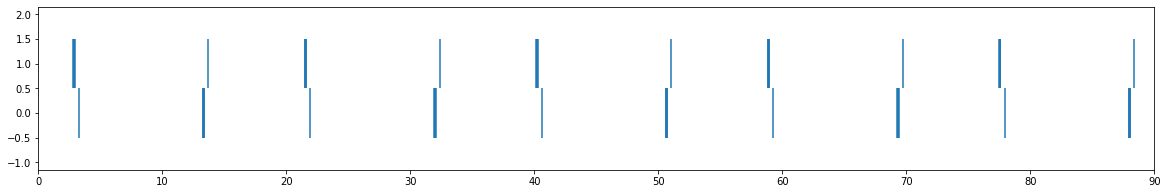

In [382]:
# test burst detection, burst statistics and activity state identification on the example
#idx[7] leiden identified clusters
j=23241
plt.figure(figsize=(20,3))
plt.eventplot([st_[0][j], st_[1][j]])
plt.xlim((0,90))
#plt.axis('off')

Burst,Burst1=[],[]
for i in range(len(st)):
  burst = DetectBursts(st_[i][j], np.mean(np.diff(st_[i][j])), np.mean(np.diff(st_[i][j]))+1, 1)
  Burst.append(burst)

  burst1 = DetectBurstingNetworks(st_[i][j])
  Burst1.append(burst1)
  

T = 90 # total time
xnetwork = Xnetwork(Burst,T)
print(xnetwork[0])
 
state = ClassifyActivity([st_[0][j], st_[1][j]])

print(state)
#print(Burst1[1]) # detectburstnetworks
#print(Burst[1]) #detectbursts

In [318]:
# identify activity state for all the models
State =[]
for j in range(len(st[0])):
  state = ClassifyActivity([st[0][j], st[1][j]])
  State.append(state)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


In [383]:
# calculate burst statistics

Burst=[]
for j in range(len(st[0])):
  burst = DetectBursts(st[i][j], np.mean(np.diff(st[i][j])), np.mean(np.diff(st[i][j]))+1, 2)
  #burst = DetectBurstingNetworks(st[0][j])
  Burst.append(burst)

# Functions to calculate percentiles of ISIs and spike phases and other spike train features 

In [46]:
# ISIs and percentiles of ISIs

def ISIPercentile(spiketimes):

  isiprtile = []

  for j in range(len(spiketimes)):

    isiprtile1=[]

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>1):
        #ISI = np.diff(np.concatenate(spiketimes[j][i]))
        ISI = np.diff(spiketimes[j][i])
        isiprtile1.append(np.percentile(ISI,range(0,100,10)).tolist())
      else:
        #isiprtile1.append([])
        isiprtile1.append([0]*10)

    isiprtile.append(isiprtile1)

  return isiprtile


In [47]:
# spike phases and phase percentiles

def PhasePrtile(spiketimes):

  phasesprtile1, phasesprtile2 = [], []

  # phases for the first neuron

  for i in range(len(spiketimes[0])):

    prevspk1,nextspk1,spkphase1 = [],[],[]
    prevspk2,nextspk2,spkphase2 = [],[],[]

    #if (spiketimes[0][i].any()) & (spiketimes[1][i].any()):
    if (len(spiketimes[0][i])!=0) & (len(spiketimes[1][i])!=0):

      #st1 = np.concatenate(spiketimes[0][i])
      #st2 = np.concatenate(spiketimes[1][i])
      st1 = spiketimes[0][i]
      st2 = spiketimes[1][i]
      
      if (max(st2)>min(st1)) & (max(st1)>min(st2)) & (len(st1)>10) & (len(st2)>10):

        # phases of the 1st neuron
        for j in range(len(st1)):

          prev_other_spikes1 = st2[np.where(st2<st1[j])]

          if not prev_other_spikes1.any():
            continue
          else:
            prev_other_spike1 = prev_other_spikes1[-1]
              
          next_other_spikes1 = st2[np.where(st2>st1[j])]

          if not next_other_spikes1.any():
            continue
          else:
            next_other_spike1 = next_other_spikes1[0]

          prevspk1.append(prev_other_spike1)
          nextspk1.append(next_other_spike1)

          spkphase1.append((st1[j] - prev_other_spike1)/(next_other_spike1 - prev_other_spike1))

        # phases of the 2nd neuron
        for j in range(len(st2)):

          prev_other_spikes2 = st1[np.where(st1<st2[j])]

          if not prev_other_spikes2.any():
            continue
          else:
            prev_other_spike2 = prev_other_spikes2[-1]
              
          next_other_spikes2 = st1[np.where(st1>st2[j])]

          if not next_other_spikes2.any():
            continue
          else:
            next_other_spike2 = next_other_spikes2[0]

          prevspk2.append(prev_other_spike2)
          nextspk2.append(next_other_spike2)

          spkphase2.append((st2[j] - prev_other_spike2)/(next_other_spike2 - prev_other_spike2))

      else:
        spkphase1, spkphase2 = [], []

      if spkphase1:
        phasesprtile1.append(np.percentile(spkphase1,range(0,100,10)))
      else:
        phasesprtile1.append([0]*10)

      if spkphase2:
        phasesprtile2.append(np.percentile(spkphase2,range(0,100,10)))
      else:
        phasesprtile2.append([0]*10)

    else:
      phasesprtile1.append([0]*10)
      phasesprtile2.append([0]*10)



  return phasesprtile1, phasesprtile2

In [48]:
# calculate firing rates

def FiringRate(spiketimes):

  FR = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):
    for i in range(len(spiketimes[j])):  
      if (len(spiketimes[j][i])>1):
        ISI = np.diff(spiketimes[j][i])
        FR[j,i] = np.median(1/ISI)
      else: 
        FR[j,i] = 0

  return FR

In [49]:
# calculate ciefficient of variation of spike trains

from scipy.stats import variation 

def ISICV(spiketimes):

  ISICV = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):
    for i in range(len(spiketimes[j])):  
      if (len(spiketimes[j][i])>1):
        ISI = np.diff(spiketimes[j][i])
        ISICV[j,i] = variation(ISI)

  return ISICV


In [50]:
# calculate a metrics for the first approximation of how burst-like spike train is

def BurstLike(spiketimes):

  burstlike = np.empty(shape=(len(spiketimes),len(spiketimes[0])))

  for j in range(len(spiketimes)):

    for i in range(len(spiketimes[j])):
      
      if (len(spiketimes[j][i])>2):
        ISI = np.diff(spiketimes[j][i])
        sortedISI = sorted(ISI)
        maxdiffs = max(np.diff(sortedISI))
        argmaxdiffs = np.argmax(np.diff(sortedISI))
        burstlike[j,i] = maxdiffs/sortedISI[argmaxdiffs]
      else:
        burstlike[j,i] = 0

  return burstlike

# Calculate percentiles of ISI and spike phases, firing rates and measure of burstiness

In [51]:
# remove asymmetric networks with one tonically spiking neuron

ISI_CV = ISICV(st) # calculate coefficient of variation of ISIs

st_ = copy.deepcopy(st)

tonic_i = np.argwhere(ISI_CV[0,:]<0.1)

delete_multiple_element(st_[0], tonic_i.T[0])
delete_multiple_element(st_[1], tonic_i.T[0])


In [384]:
# exclude asymmetric tonic
State_ = copy.deepcopy(State)
delete_multiple_element(State_, tonic_i.T[0])
Burst_ = copy.deepcopy(Burst)
delete_multiple_element(Burst_, tonic_i.T[0])

In [36]:
# caluclate features of all the networks 
isiprtile = ISIPercentile(st) # percentiles of ISIs 
phaseprtile = PhasePrtile(st) # percentiles of spike phases
FR = FiringRate(st) # median firing rates
burstlike = BurstLike(st) # how burstlike the spike train is

In [53]:
# caluclate features of all the networks except asymmetric tonic 

isiprtile = ISIPercentile(st_) # percentiles of ISIs 
phaseprtile = PhasePrtile(st_) # percentiles of spike phases
FR = FiringRate(st_) # median firing rates
burstlike = BurstLike(st_) # how burstlike the spike train is

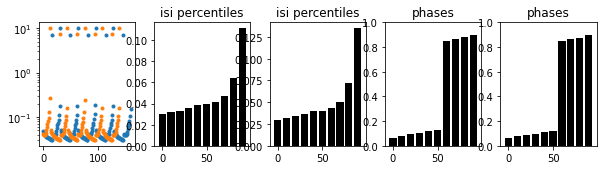

In [101]:
# plot example ISIs, spike phases and ISI and phases tenth percentiles

i=3

plt.figure(figsize=(10,5))
plt.subplot(2,5,1)
for j in [0,1]:
  plt.plot(np.diff(st_[j][i]),'.')
  plt.yscale('log')

for j in [0,1]:
  plt.subplot(2,5,j+2)
  plt.bar(range(0,100,10), isiprtile[j][i],width=8,color='black') #isiprtile
  plt.title('isi percentiles')

for j in [0,1]:
  plt.subplot(2,5,j+4)
  plt.bar(range(0,100,10), phaseprtile[j][i],width=8,color='black') # spike phases
  plt.ylim(0,1)
  plt.title('phases')

#plt.subplot(2,5,7)
#plt.bar(range(0,100,10), allprtile[i][:10],width=8,color='black')
#plt.subplot(2,5,8)
#plt.bar(range(0,100,10), allprtile[i][10:20],width=8,color='black')
#plt.subplot(2,5,9)
#plt.bar(range(0,100,10), allprtile[i][20:30],width=8,color='black')
#plt.ylim(0, 1)
#plt.subplot(2,5,10)
#plt.bar(range(0,100,10), allprtile[i][30:40],width=8,color='black')
#plt.ylim(0, 1)


In [102]:
# make a feature vector and z-score it

features = np.hstack((isiprtile[0], isiprtile[1], phaseprtile[0], phaseprtile[1]))
features1 = np.append(features, FR.T, axis=1)
features2 = np.append(features1, burstlike.T, axis=1)
scaled_features = zscore(features2)

# FIt-SNE approximate algorithm (FFT-accelerated Interpolation-based t-SNE)

In [ ]:
#@title Clone FFT-accelerated t-SNE repository
import os, requests
import sys

!git clone https://github.com/KlugerLab/FIt-SNE.git 
!apt-get install libfftw3-dev
!g++ -std=c++11 -O3  /content/FIt-SNE/src/sptree.cpp /content/FIt-SNE/src/tsne.cpp /content/FIt-SNE/src/nbodyfft.cpp  -o /content/FIt-SNE/bin/fast_tsne -pthread -lfftw3 -lm -Wno-address-of-packed-member

sys.path.append(os.path.abspath('/content/FIt-SNE/'))
from fast_tsne import fast_tsne 

In [41]:
# Do PCA and keep 50 dimensions

X = scaled_features.copy()
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:,:50]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-97.26422762055019, 91.02827653522806, -73.866430447588, 77.4177644071471)

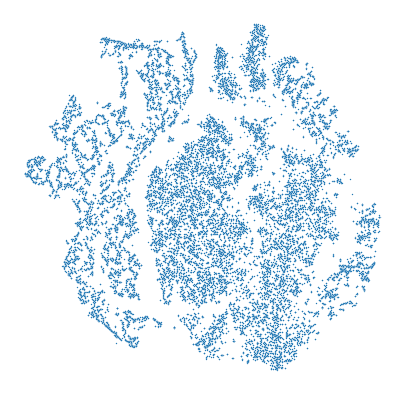

In [69]:
# calculate and plot tsne

#Z = fast_tsne(allprtile_scaled, perplexity=50, stop_early_exag_iter=250)
Z = fast_tsne(X50, perplexity=50, stop_early_exag_iter=250)

plt.figure(figsize=(7,7))
sns.scatterplot(Z[:,0], Z[:,1], s=2, c='black')
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-68.34539835869175, 60.51405279787847, -38.56299465474837, 51.138702101554735)

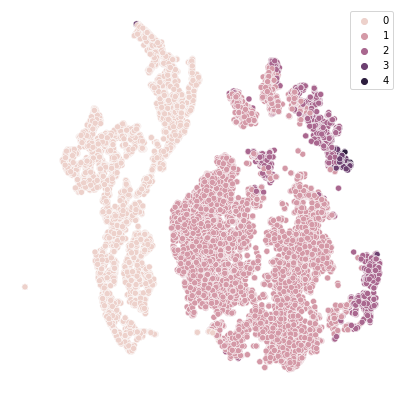

In [ ]:
# K-means clustering

#kmeans = KMeans(n_clusters=5, random_state=0).fit(Z)
#kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_features)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X50)

plt.figure(figsize=(7,7))
sns.scatterplot(Z[:,0], Z[:,1],hue = kmeans.labels_, s=3)
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-68.34539835869175, 60.51405279787847, -38.56299465474837, 51.138702101554735)

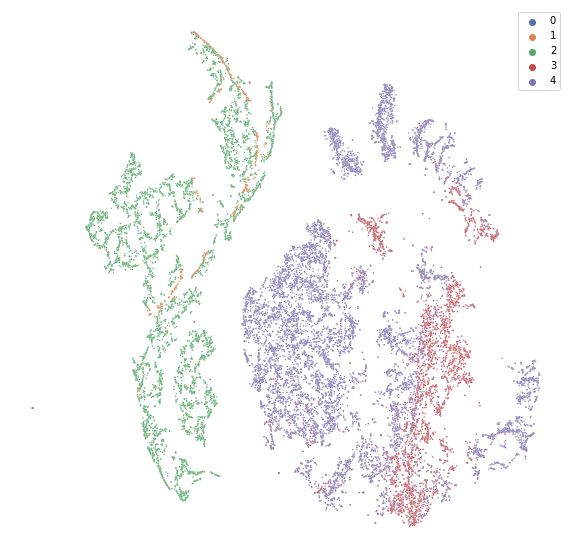

In [ ]:
# Colorcode t-SNE by state

plt.figure(figsize=(10,10))
sns.scatterplot(Z[:,0], Z[:,1], s=2, hue = State_, palette='deep')
plt.axis("off")

In [ ]:
# try embedding with open tSNE
pip install opentsne

In [71]:
from openTSNE import TSNE

embeddings = []

tsne = TSNE(
    perplexity=100, n_iter=500, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: embeddings.append(np.array(emb)),
    # This should be done on every iteration
    callbacks_every_iters=1,
)
#metric="euclidean"

%time tsne_embedding = tsne.fit(X50)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f4b22ed75f0>, callbacks_every_iters=1,
     metric='cosine', n_jobs=32, perplexity=100, verbose=True)
--------------------------------------------------------------------------------
===> Finding 300 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 26.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 3.17 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=1940.33 for 250 iterations...
Iteration   50, KL divergence 4.2125, 50 iterations in 22.2158 sec
Iteration  100, KL divergence 3.7881, 50 iterations in 29.6851 sec
Iteration  150, KL divergence 3.7010, 50 iterations in 24.7873 sec
Iteration  200, KL divergence 3.6624, 50 iterations in 27.5842 sec
Iteration  250, KL divergence 3.6408, 50 iterations in 19.8051 sec
  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-75.95561617974504,
 67.28925838982487,
 -59.239216453885945,
 56.067481503605144)

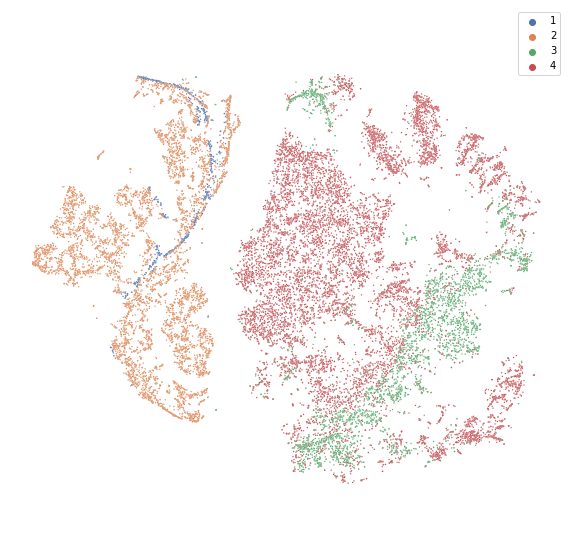

In [72]:
# plot the embedding
plt.figure(figsize=(10,10))
plt.axis('equal')
sns.scatterplot(tsne_embedding[:,0], tsne_embedding[:,1], hue = State_, palette='deep', s=2, edgecolors='none')
sns.despine()
plt.axis("off")

In [54]:
#animate tsne
import matplotlib.animation as animation

In [73]:
# animation

%%time
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([]), ax.set_yticks([])

#colors = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
#                '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'])

colors = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#e31a1c'])


pathcol = ax.scatter(embeddings[0][:, 0], embeddings[0][:, 1], c=colors[State_], s=2, rasterized=True, edgecolors='none')
#pathcol = sns.scatterplot(embedding[:,0], embedding[:,1], hue = State_, palette='deep', s=2, edgecolors='none')


def update(embedding, ax, pathcol):
    # Update point positions
    pathcol.set_offsets(embedding)
    
    # Adjust x/y limits so all the points are visible
    ax.set_xlim(np.min(embedding[:, 0]), np.max(embedding[:, 0]))
    ax.set_ylim(np.min(embedding[:, 1]), np.max(embedding[:, 1]))
    
    #ax.set_xlim(-80, 80)
    #ax.set_ylim(-80, 80)
    
    return [pathcol]

anim = animation.FuncAnimation(
    fig, update, fargs=(ax, pathcol), interval=20,
    frames=embeddings, blit=True,
)

anim.save("HCO.mp4", dpi=150, writer="ffmpeg")
plt.close()

CPU times: user 1min 31s, sys: 1.94 s, total: 1min 33s
Wall time: 1min 46s


# Scanpy Leiden clustering, t-SNE visulization

In [103]:
# make annotated data matrix from the spike train featues

adata = sc.AnnData(scaled_features, dtype=np.float32)
print(adata)
#need to add conductance to adata
#var: 'conductances'

AnnData object with n_obs × n_vars = 23284 × 44


In [104]:
#Computing the neighborhood graph and cluster spiking patterns using the Leiden algorithm
# uses a neighborhood graph as the distance matrix, so we need to first calculate the graph.

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
#sc.pp.neighbors(adata, method="umap", n_neighbors=10)
sc.tl.leiden(adata, key_added='clusters', resolution=0.1)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


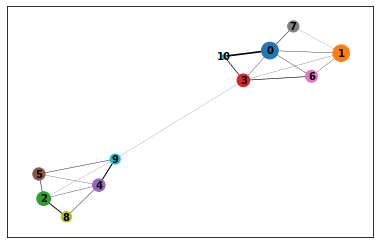

In [125]:
# partition-based graph abstraction 
sc.tl.paga(adata,groups='clusters')
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph

In [107]:
# t-SNE
#sc.tl.tsne(adata,perplexity=100,n_pcs=10)
sc.tl.tsne(adata,perplexity=100, random_state=1)

computing tSNE
    using data matrix X directly
    using sklearn.manifold.TSNE


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:06:34)


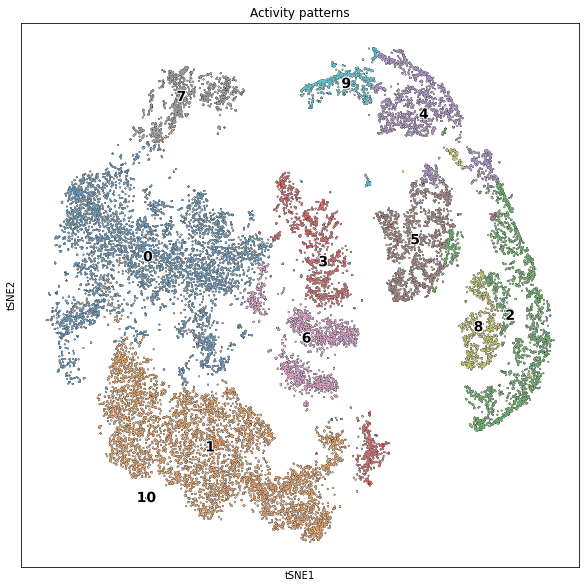

In [108]:
# plot t-SNE

with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.tsne(adata, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=14, legend_fontoutline=2, frameon=True,
               title='Activity patterns', palette='tab10')
  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

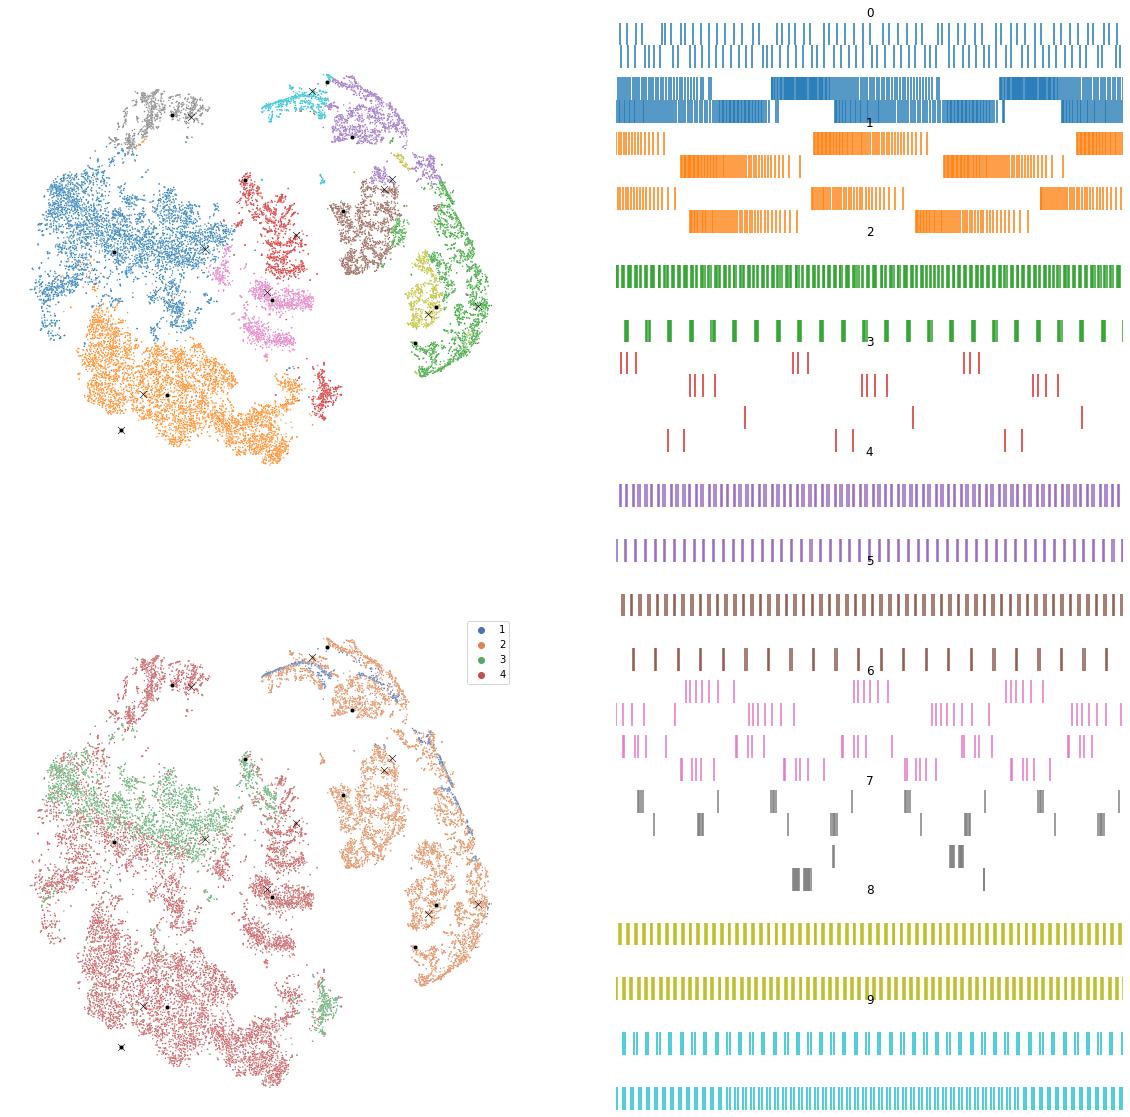

In [232]:
# plot t-SNE colorcoded by Leiden clusters and example spiking patterns

plt.figure(figsize=(20,20))

#cmap=plt.cm.get_cmap('Set1')
cmap=plt.cm.get_cmap('tab10')
palette = sns.color_palette(None, 10)

ax=plt.subplot(2,2,1)
sns.scatterplot(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], s=2, hue = adata.obs.clusters, palette=sns.color_palette(None,len(adata.obs.clusters.unique())),edgecolors='black')
# examples
sns.scatterplot(adata.obsm['X_tsne'][clusters_idx1,0], adata.obsm['X_tsne'][clusters_idx1,1], s=20, color = 'black')
sns.scatterplot(adata.obsm['X_tsne'][clusters_idx2,0], adata.obsm['X_tsne'][clusters_idx2,1], s=50, color = 'black',marker="x")
ax.set_aspect('equal')
plt.axis('off')
ax.get_legend().remove()

plt.subplot(2,2,3)
sns.scatterplot(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], s=2, hue = State_, palette='deep',edgecolors='black')
# examples
sns.scatterplot(adata.obsm['X_tsne'][clusters_idx1,0], adata.obsm['X_tsne'][clusters_idx1,1], s=20, color = 'black')
sns.scatterplot(adata.obsm['X_tsne'][clusters_idx2,0], adata.obsm['X_tsne'][clusters_idx2,1], s=50, color = 'black',marker="x")
ax.set_aspect('equal')
plt.axis('off')


for i in range(10):

  #plt.subplot(10,2,2*(i+1))
  #plt.eventplot([st_[0][clusters_idx[i]], st_[1][clusters_idx[i]]], colors = palette[i])
  #plt.ylim(-0.5,1.5)
  #plt.xlim(0,10)
  #plt.axis('off')
  #plt.title(str(i))

  plt.subplot(20,2,4*(i+1))
  plt.eventplot([st_[0][clusters_idx1[i]], st_[1][clusters_idx1[i]]], colors = palette[i])
  plt.ylim(-0.5,1.5)
  plt.xlim(0,20)
  plt.axis('off')

  plt.subplot(20,2,4*(i)+2)
  plt.eventplot([st_[0][clusters_idx2[i]], st_[1][clusters_idx2[i]]], colors = palette[i])
  plt.ylim(-0.5,1.5)
  plt.xlim(0,20)
  plt.axis('off')
  plt.title(str(i))


# Scanpy UMAP, Leiden 

In [466]:
# umap uses a neighborhood graph as the distance matrix, so we need to first calculate the graph.

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
#sc.pp.neighbors(adata, method="umap", n_neighbors=10)
sc.tl.leiden(adata, key_added='clusters', resolution=0.1)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:02)


In [498]:
# UMAP   

#sc.tl.umap(adata,min_dist=0.1,gamma=0.1,init_pos=Z)
#sc.tl.umap(adata,min_dist=0.5,gamma=0.1,init_pos='paga')
#sc.tl.umap(adata,min_dist=0.2,gamma=1,spread=1, init_pos='paga')

#sc.tl.umap(adata,min_dist=0.1,gamma=0.5,init_pos='spectral')
sc.tl.umap(adata,min_dist=0.1,gamma=0.5,init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


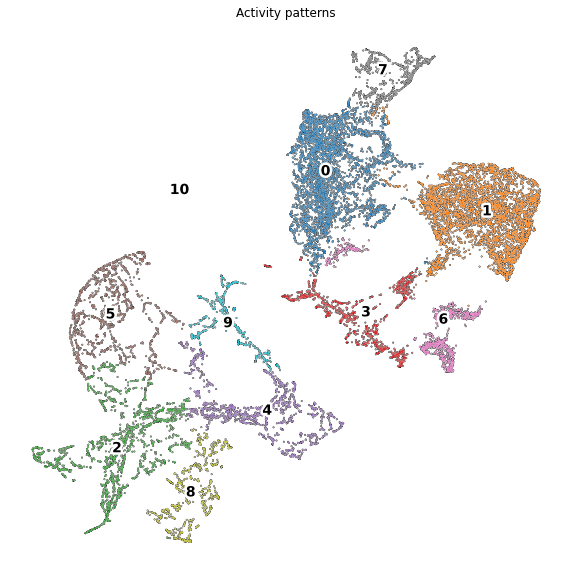

In [499]:
# plot uMAP   
with rc_context({'figure.figsize': (10, 10)}):
 sc.pl.umap(adata, color='clusters', add_outline=True, legend_loc='on data',
                legend_fontsize=14, legend_fontoutline=5,frameon=False,
                title='Activity patterns', palette='tab10')


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.06', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.09', the cluster labels (adata.obs, categorical) (0:00:01)


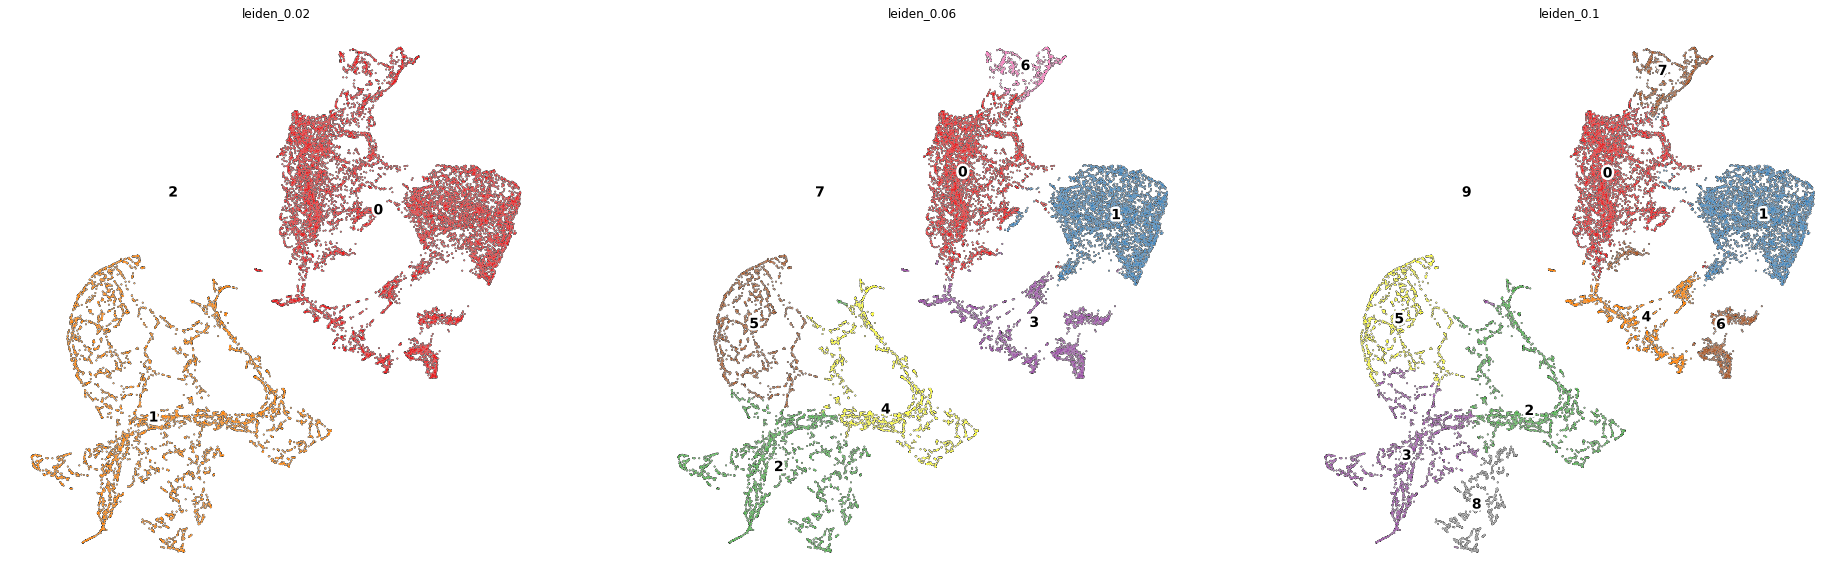

In [500]:
# effect of leiden resolution on the number of clusters
sc.tl.leiden(adata, resolution = 0.02, key_added = "leiden_0.02")
sc.tl.leiden(adata, resolution = 0.06, key_added = "leiden_0.06")
sc.tl.leiden(adata, resolution = 0.09, key_added = "leiden_0.09")
#sc.pl.umap(adata, color=['leiden_0.02', 'leiden_0.05', 'leiden_0.07','leiden_0.1'])

with rc_context({'figure.figsize': (10, 10)}):
 sc.pl.umap(adata, color=['leiden_0.02', 'leiden_0.06','leiden_0.1'], add_outline=True, legend_loc='on data',
                legend_fontsize=14, legend_fontoutline=5,frameon=False,palette='Set1')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden_0.06']`


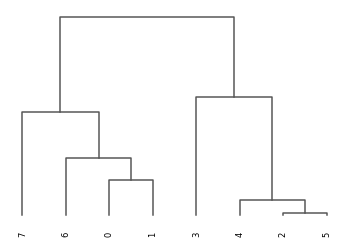

In [494]:
# Once we have done clustering, the relationships between clusters can be calculated as correlation in PCA space
sc.tl.dendrogram(adata, groupby = "leiden_0.06")
sc.pl.dendrogram(adata, groupby = "leiden_0.06")
#conductaces  = ["Na", "K", "A", "CaS","CaT", "H","Leak"]
#sc.pl.dotplot(adata, genes, groupby='leiden_0.6', dendrogram=True)

In [495]:
adata

AnnData object with n_obs × n_vars = 23284 × 44
    obs: 'clusters', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'leiden_0.02', 'leiden_0.05', 'leiden_0.07', 'leiden_0.1', 'leiden_0.08', 'leiden_0.09', 'leiden_0.06'
    uns: 'neighbors', 'leiden', 'paga', 'clusters_sizes', 'tsne', 'clusters_colors', 'umap', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_1.0_colors', 'leiden_1.4_colors', 'leiden_0.02_colors', 'leiden_0.05_colors', 'leiden_0.07_colors', 'leiden_0.1_colors', 'leiden_0.06_colors', 'dendrogram_leiden_0.06'
    obsm: 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


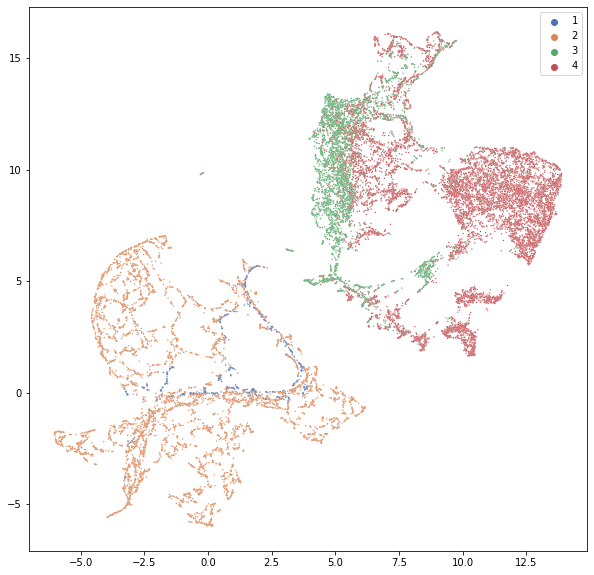

In [501]:
plt.figure(figsize=(10,10))
cmap=plt.cm.get_cmap('Set1')
sns.scatterplot(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=2, hue = State_, palette='deep')

In [287]:
# get indexes of identified clusters
idx=[]
clusters_idx1=[0]*11
clusters_idx2=[0]*11

for i in range(11):
  clusters_= adata.obs.clusters==str(i)
  idxx = clusters_.index[clusters_==True]
  idx.append(idxx)
  clusters_idx1[i] = int(idx[i][13])
  clusters_idx2[i] = int(idx[i][7])

In [302]:
# organize cluster numbers in a more meaningful way
# bursters
# 0) 1,
# 1) 6
# 2) 3
#irregular
# 3) 0
# 4) 7
# asymmetric
# 5) 9
# 6) 4
# 7) 2
# 8) 5
# 9) 8

k=0;
for i in [1,6,3,0,7,9,4,2,5,8]:
  clusters_= adata.obs.clusters==str(1)
  idxx = clusters_.index[clusters_==True]
  idx.append(idxx)
  #clusters_idx1[k] = int(idx[i][13])
  #clusters_idx2[k] = int(idx[i][7])
  clusters_idx1[k] = int(idx[i][15])
  clusters_idx2[k] = int(idx[i][9])
  k=k+1;

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

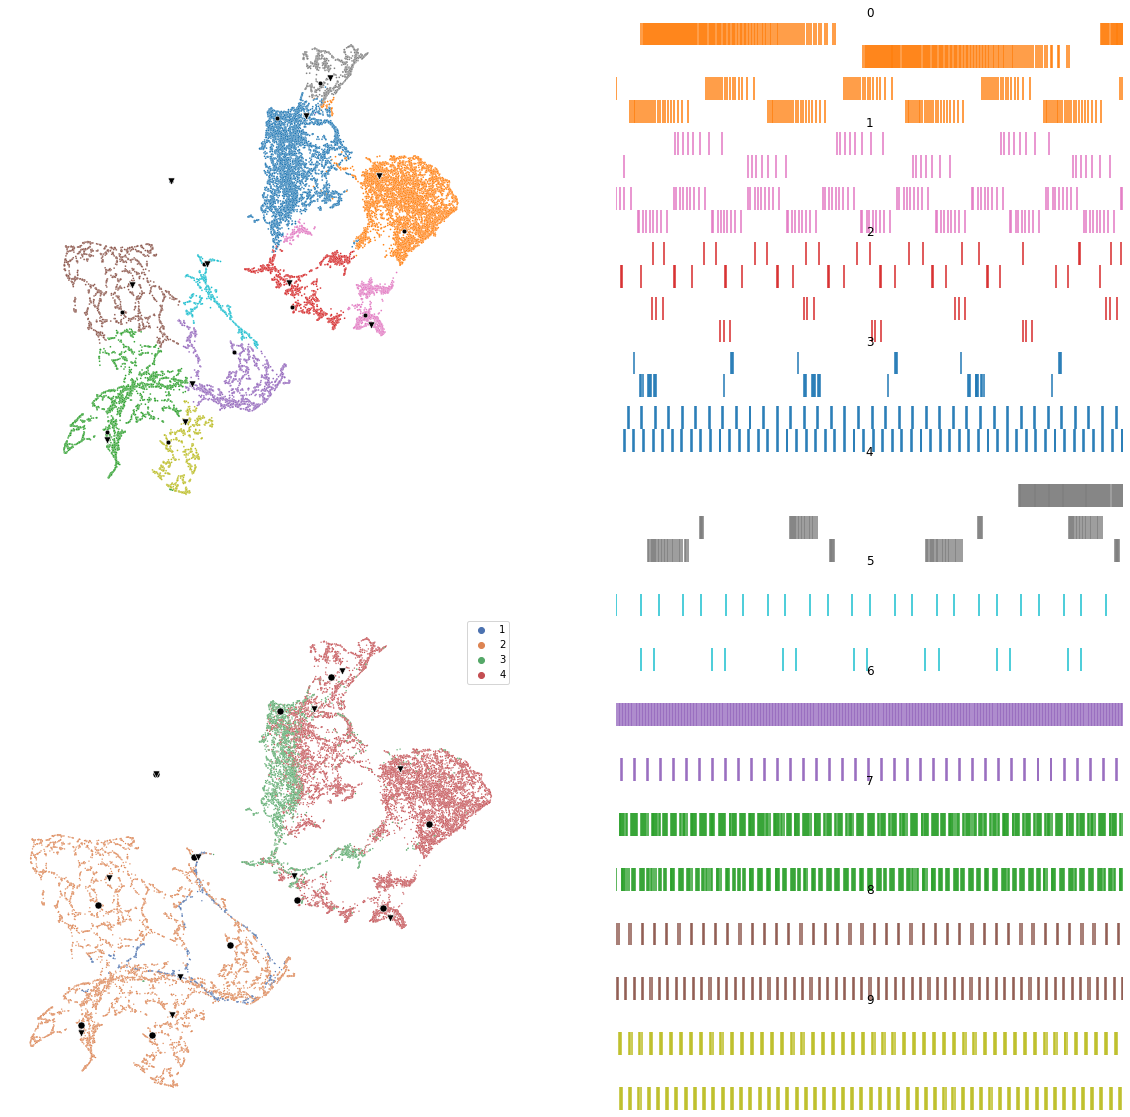

In [303]:
 # plot uMAP colorcoded by Leiden clusters and by manually identified states and example spiking patterns

plt.figure(figsize=(20,20))

cmap=plt.cm.get_cmap('Set1')
palette = sns.color_palette(None, 10)

ax=plt.subplot(2,2,1)
sns.scatterplot(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=3, hue = adata.obs.clusters, palette=sns.color_palette(None,len(adata.obs.clusters.unique())))
# examples
sns.scatterplot(adata.obsm['X_umap'][clusters_idx1,0], adata.obsm['X_umap'][clusters_idx1,1], s=20, color = 'black')
sns.scatterplot(adata.obsm['X_umap'][clusters_idx2,0], adata.obsm['X_umap'][clusters_idx2,1], s=50, color = 'black',marker="v")
ax.set_aspect('equal')
plt.axis('off')
ax.get_legend().remove()

plt.subplot(2,2,3)
sns.scatterplot(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=2, hue = State_, palette='deep')
# examples
sns.scatterplot(adata.obsm['X_umap'][clusters_idx1,0], adata.obsm['X_umap'][clusters_idx1,1], s=50, color = 'black')
sns.scatterplot(adata.obsm['X_umap'][clusters_idx2,0], adata.obsm['X_umap'][clusters_idx2,1], s=50, color = 'black',marker="v")
ax.set_aspect('equal')
plt.axis('off')

ii = [1,6,3,0,7,9,4,2,5,8]
for i in range(10):

  #plt.subplot(10,2,2*(i+1))
  #plt.eventplot([st_[0][clusters_idx[i]], st_[1][clusters_idx[i]]], colors = palette[i])
  #plt.ylim(-0.5,1.5)
  #plt.xlim(0,20)
  #plt.axis('off')
  #plt.title(str(i))

  plt.subplot(20,2,4*(i+1))
  plt.eventplot([st_[0][clusters_idx1[i]], st_[1][clusters_idx1[i]]], colors = palette[ii[i]])
  plt.ylim(-0.5,1.5)
  plt.xlim(0,20)
  plt.axis('off')

  plt.subplot(20,2,4*(i)+2)
  plt.eventplot([st_[0][clusters_idx2[i]], st_[1][clusters_idx2[i]]], colors = palette[ii[i]])
  plt.ylim(-0.5,1.5)
  plt.xlim(0,20)
  plt.axis('off')
  plt.title(str(i))


# Colorcoding embedding based on different features

In [386]:
# colorcode based on the firing rate of the more active neuron

fr = FiringRate(st_) # median firing rates
isicv = ISICV(st_) # coefficient of variation of interspike interval

sortedfr = sorted(fr[0,:])
sortedfr_idx = np.argsort(fr[0,:])
sortedisicv = sorted(isicv[0,:])
sortedisicv_idx = np.argsort(isicv[0,:])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


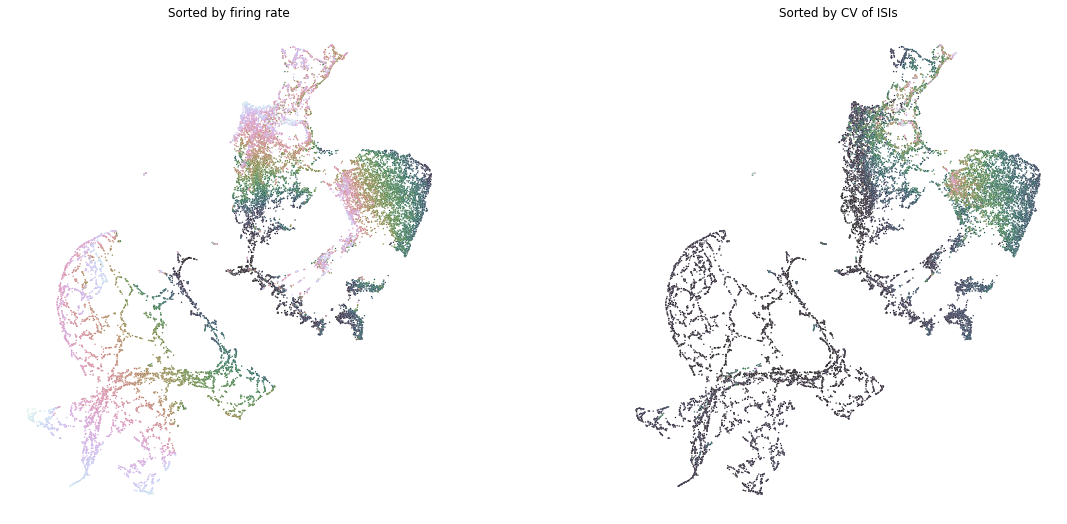

In [502]:
plt.figure(figsize=(20,20))

ax=plt.subplot(2,2,1)
sns.scatterplot(adata.obsm['X_umap'][sortedfr_idx,0], adata.obsm['X_umap'][sortedfr_idx,1], s=2, hue = sortedfr, palette='cubehelix')
plt.title('Sorted by firing rate')
ax.set_aspect('equal')
plt.axis('off')
ax.get_legend().remove()

ax=plt.subplot(2,2,2)
sns.scatterplot(adata.obsm['X_umap'][sortedisicv_idx,0], adata.obsm['X_umap'][sortedisicv_idx,1], s=2, hue = sortedisicv, palette='cubehelix')
plt.title('Sorted by CV of ISIs')
ax.set_aspect('equal')
plt.axis('off')
ax.get_legend().remove()

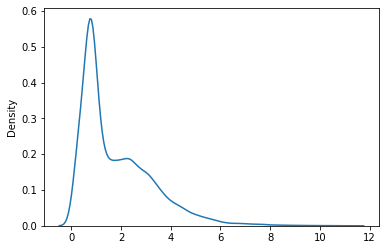

In [451]:
sns.kdeplot(data=isicv[0,:])
